# Présentation du Solveur FEM pour l'Équation de Helmholtz

Ce notebook présente les fonctionnalités du solveur d'éléments finis pour l'équation de Helmholtz:
$$-\Delta u + \kappa^2 u = f$$
sur le domaine carré unitaire $(0,1)^2$ avec conditions aux limites de Dirichlet homogènes.


## 1. Configuration et imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')

# Imports des modules du projet
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.solver import FEMSolver
from src.mesh_square import SquareMesh, create_square_obstacle, create_square_obstacle_at_position
from src.mesh_triangle import EquilateralMesh

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Configuration terminée!")

✅ Configuration terminée!


## 2. Maillages carrés

Explorons d'abord les maillages carrés structurés avec différentes résolutions.

🔹 Maillages carrés avec différentes résolutions


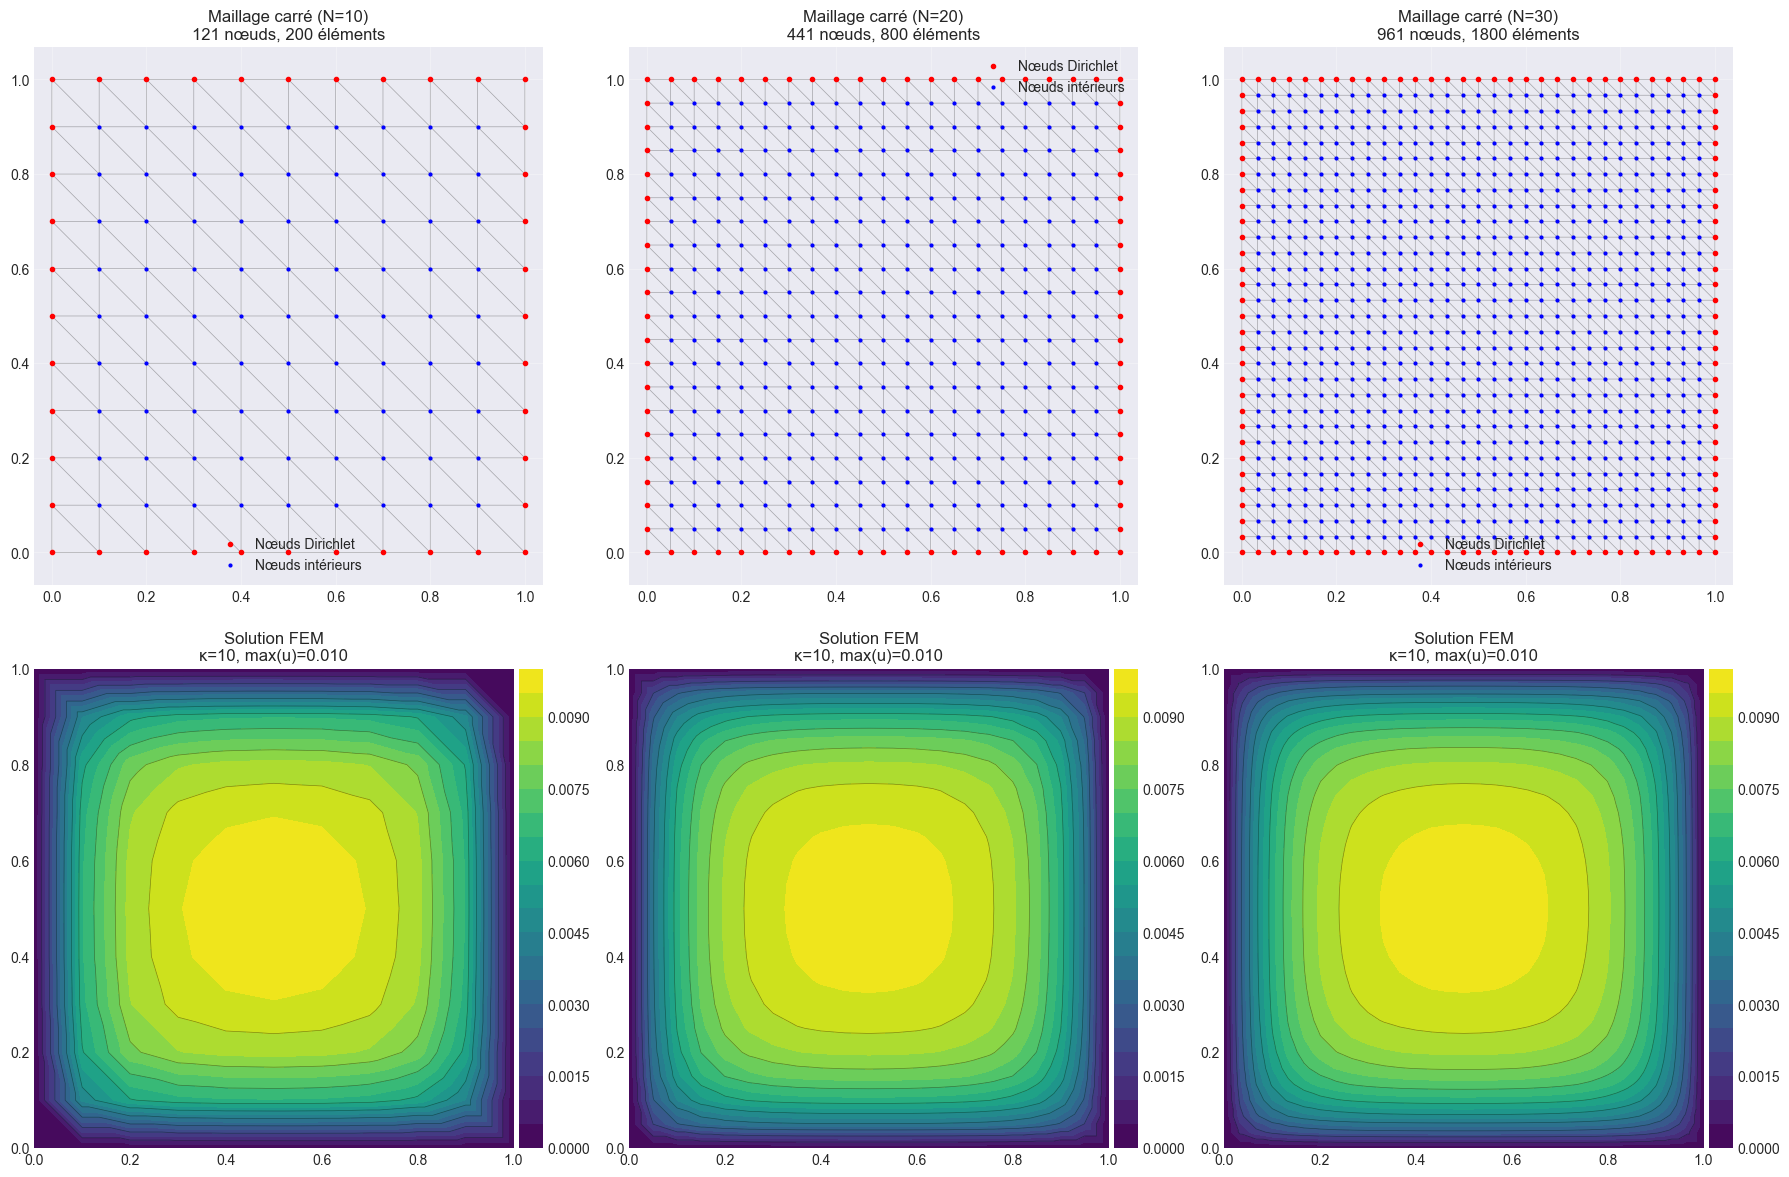

In [22]:
# Exemples avec différentes résolutions dans un seul graphique
N_values = [10, 20, 30]
kappa = 10

print("🔹 Maillages carrés avec différentes résolutions")

# Création du graphique avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, N in enumerate(N_values):
    # Génération du maillage
    mesh = SquareMesh(N).build()
    
    # Résolution
    solver = FEMSolver(mesh, kappa=kappa, f_val=1)
    solution = solver.solve()
    
    # Triangulation pour visualisation
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    
    # Première ligne : Maillages
    axes[0, i].triplot(tri, 'k-', alpha=0.3, linewidth=0.5)
    axes[0, i].plot(mesh.nodes[mesh.is_dirichlet, 0], mesh.nodes[mesh.is_dirichlet, 1], 
                    'ro', markersize=3, label='Nœuds Dirichlet')
    axes[0, i].plot(mesh.nodes[~mesh.is_dirichlet, 0], mesh.nodes[~mesh.is_dirichlet, 1], 
                    'bo', markersize=2, label='Nœuds intérieurs')
    axes[0, i].set_title(f'Maillage carré (N={N})\n{len(mesh.nodes)} nœuds, {len(mesh.elements)} éléments')
    axes[0, i].legend()
    axes[0, i].axis('equal')
    axes[0, i].grid(True, alpha=0.3)
    
    # Deuxième ligne : Solutions
    im = axes[1, i].tricontourf(tri, solution, levels=20, cmap='viridis')
    axes[1, i].tricontour(tri, solution, levels=10, colors='black', alpha=0.4, linewidths=0.5)
    axes[1, i].set_title(f'Solution FEM\nκ={kappa}, max(u)={np.max(solution):.3f}')
    axes[1, i].axis('equal')
    
    # Barre de couleur
    divider = make_axes_locatable(axes[1, i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### Analyse de convergence pour les maillages carrés

📊 Analyse de convergence...
N= 5:   36 nœuds,   50 éléments, max(u)=0.0099
N=10:  121 nœuds,  200 éléments, max(u)=0.0098
N=15:  256 nœuds,  450 éléments, max(u)=0.0098
N=15:  256 nœuds,  450 éléments, max(u)=0.0098
N=20:  441 nœuds,  800 éléments, max(u)=0.0098
N=20:  441 nœuds,  800 éléments, max(u)=0.0098
N=25:  676 nœuds, 1250 éléments, max(u)=0.0097
N=25:  676 nœuds, 1250 éléments, max(u)=0.0097
N=30:  961 nœuds, 1800 éléments, max(u)=0.0098
N=30:  961 nœuds, 1800 éléments, max(u)=0.0098


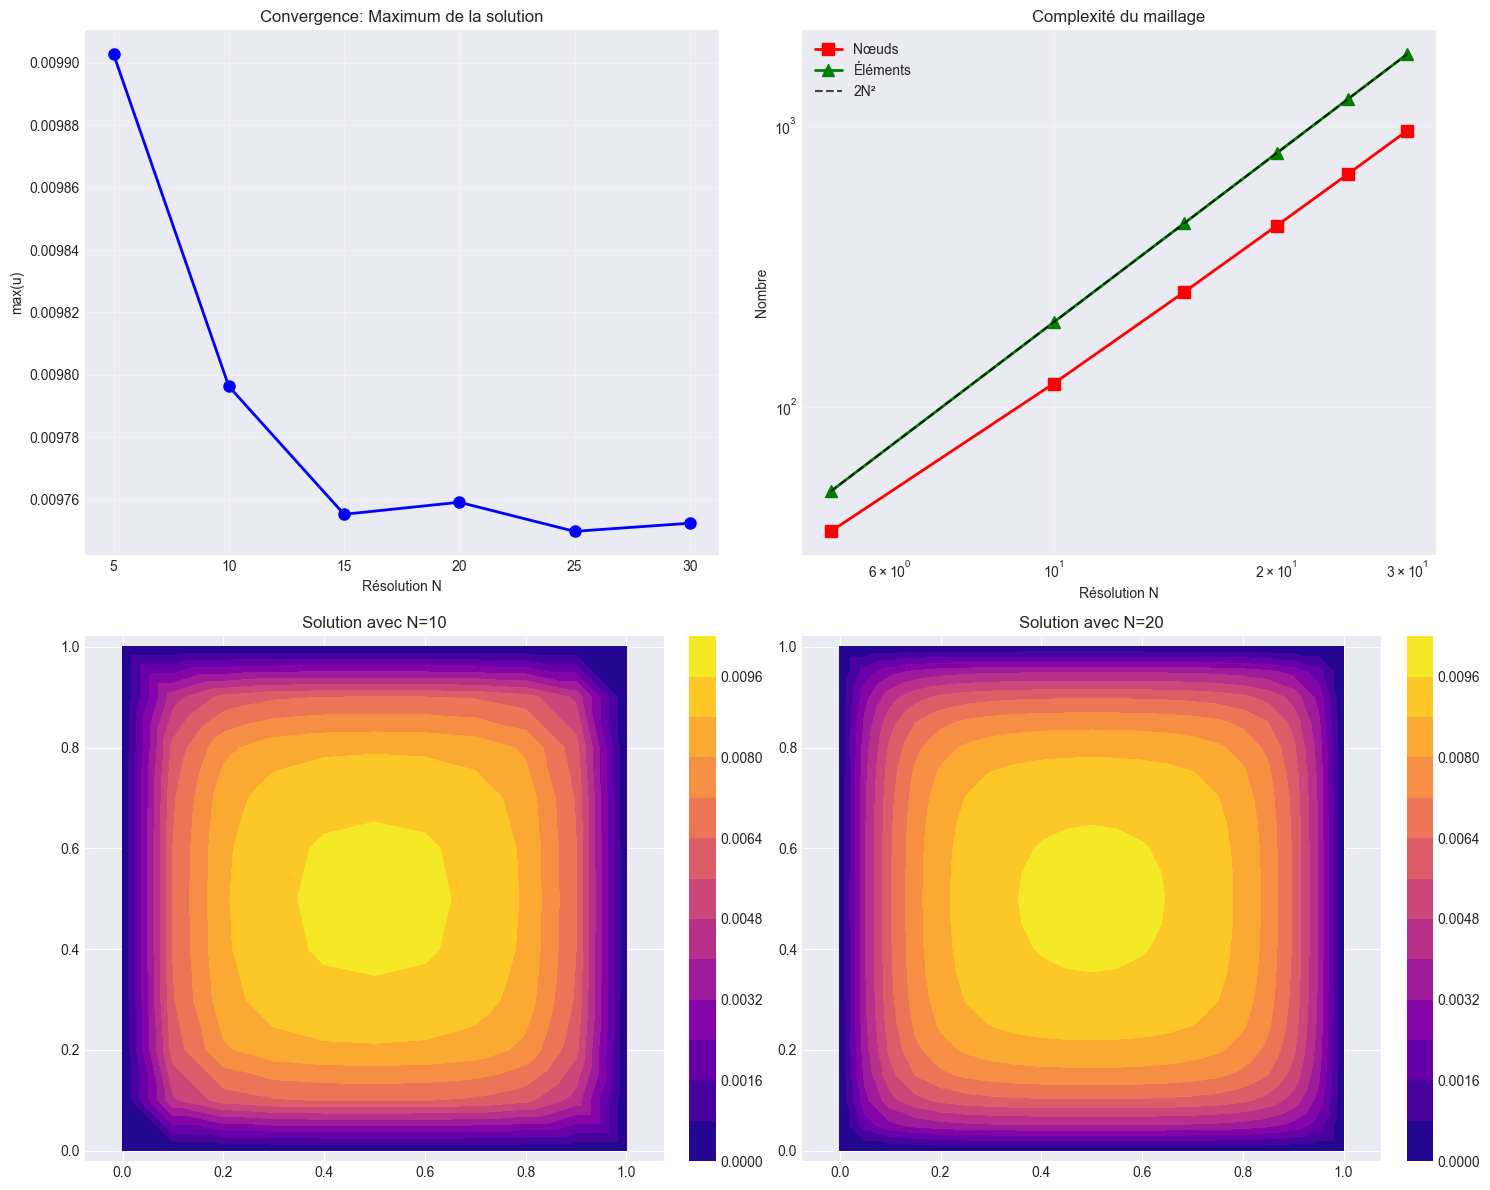

In [9]:
# Étude de convergence
N_values = [5, 10, 15, 20, 25, 30]
kappa = 10
f_val = 1

solutions = []
max_values = []
num_nodes = []
num_elements = []

print("📊 Analyse de convergence...")

for N in N_values:
    mesh = SquareMesh(N).build()
    solver = FEMSolver(mesh, kappa=kappa, f_val=f_val)
    solution = solver.solve()
    
    solutions.append(solution)
    max_values.append(np.max(solution))
    num_nodes.append(len(mesh.nodes))
    num_elements.append(len(mesh.elements))
    
    print(f"N={N:2d}: {len(mesh.nodes):4d} nœuds, {len(mesh.elements):4d} éléments, max(u)={np.max(solution):.4f}")

# Graphiques de convergence
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Évolution du maximum de la solution
ax1.plot(N_values, max_values, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Résolution N')
ax1.set_ylabel('max(u)')
ax1.set_title('Convergence: Maximum de la solution')
ax1.grid(True, alpha=0.3)

# Nombre de nœuds vs résolution
ax2.loglog(N_values, num_nodes, 'rs-', linewidth=2, markersize=8, label='Nœuds')
ax2.loglog(N_values, num_elements, 'g^-', linewidth=2, markersize=8, label='Éléments')
ax2.loglog(N_values, [2*N**2 for N in N_values], 'k--', alpha=0.7, label='2N²')
ax2.set_xlabel('Résolution N')
ax2.set_ylabel('Nombre')
ax2.set_title('Complexité du maillage')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Solutions pour différentes résolutions
for i, N in enumerate([10, 20, 30]):
    mesh = SquareMesh(N).build()
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    
    if i == 0:
        ax = ax3
    else:
        ax = ax4 if i == 1 else ax4
        continue  # On ne montre que N=10 et N=20 pour l'espace
    
    im = ax.tricontourf(tri, solutions[N_values.index(N)], levels=15, cmap='plasma')
    ax.set_title(f'Solution avec N={N}')
    ax.axis('equal')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Solution avec N=20 pour ax4
mesh = SquareMesh(20).build()
tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
im = ax4.tricontourf(tri, solutions[N_values.index(20)], levels=15, cmap='plasma')
ax4.set_title('Solution avec N=20')
ax4.axis('equal')
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 3. Maillages triangulaires équilatéraux

Explorons maintenant les maillages triangulaires équilatéraux.

🔸 Maillages triangulaires avec différentes résolutions


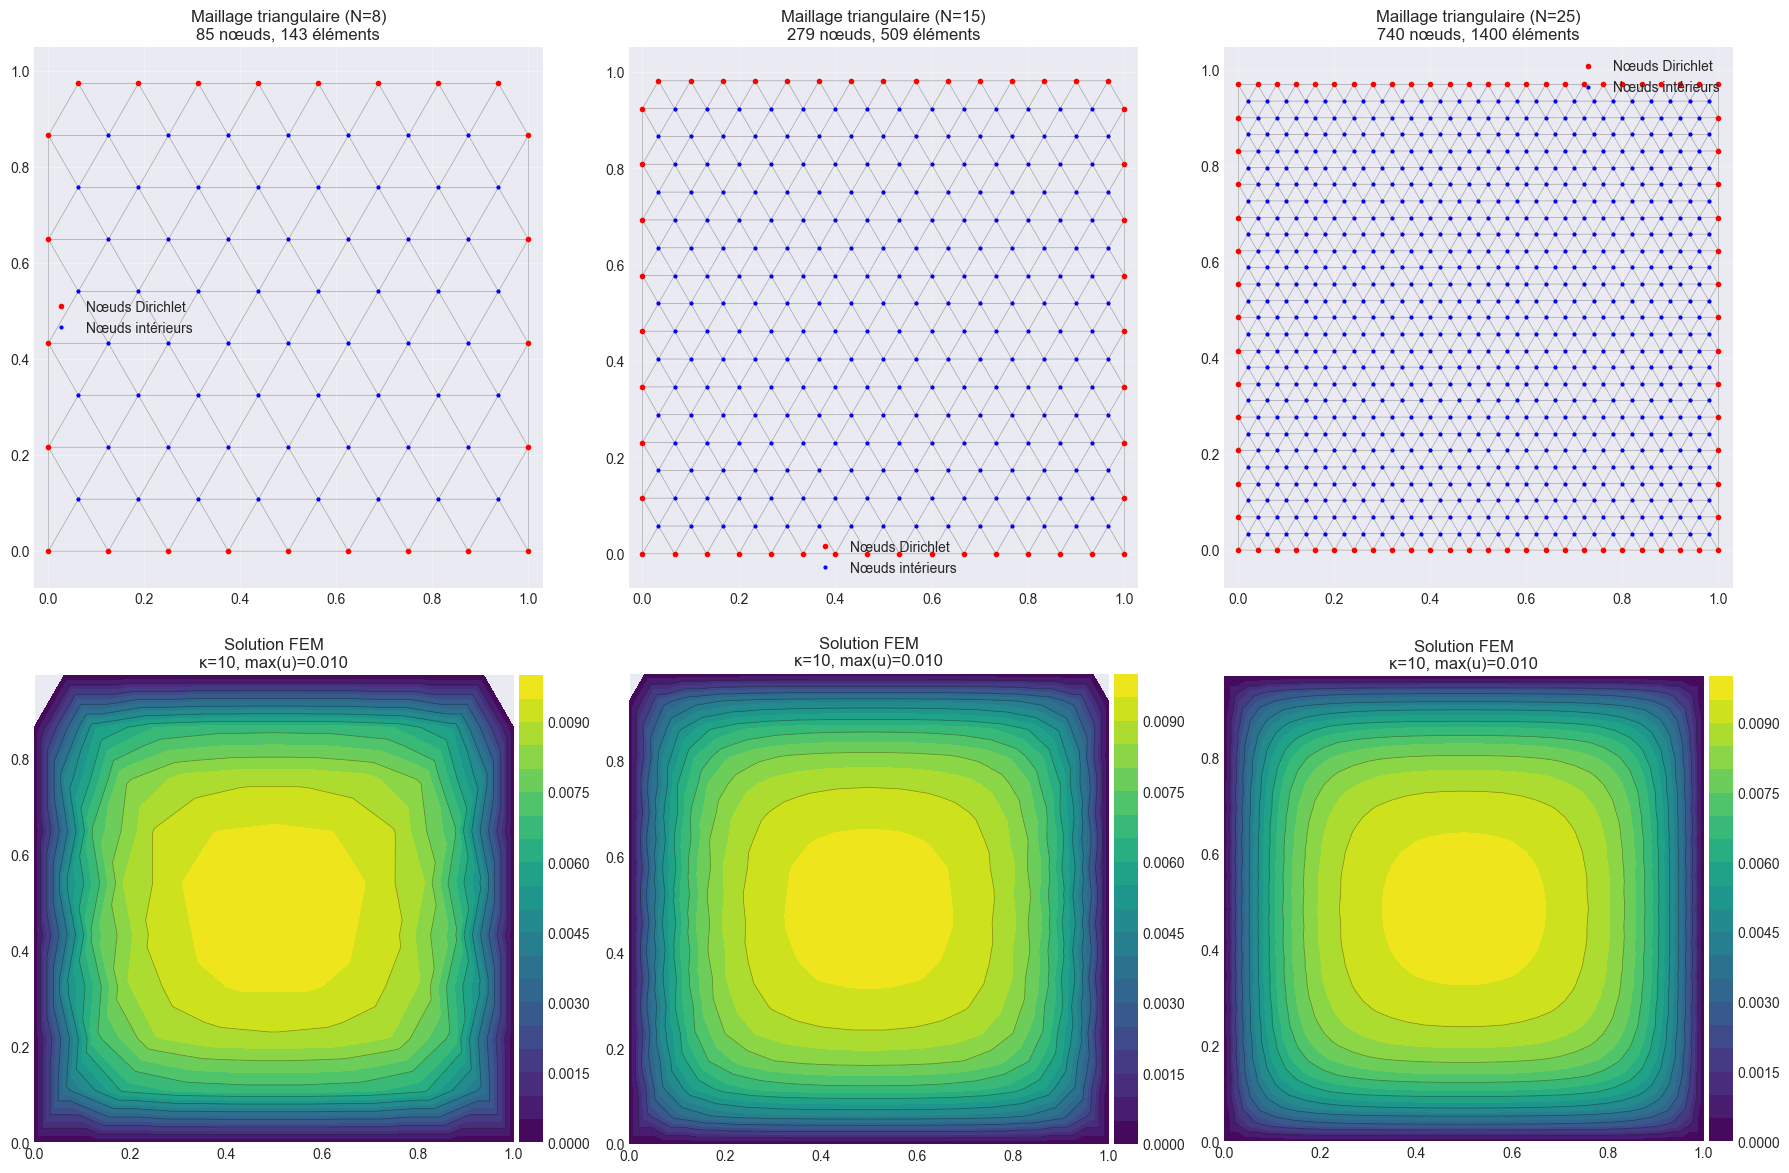

In [24]:
# Exemples avec différentes résolutions dans un seul graphique
N_values = [8, 15, 25]
kappa = 10

print("🔸 Maillages triangulaires avec différentes résolutions")

# Création du graphique avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, N in enumerate(N_values):
    # Génération du maillage
    mesh = EquilateralMesh(N).build()
    
    # Résolution
    solver = FEMSolver(mesh, kappa=kappa, f_val=1)
    solution = solver.solve()
    
    # Triangulation pour visualisation
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    
    # Première ligne : Maillages
    axes[0, i].triplot(tri, 'k-', alpha=0.3, linewidth=0.5)
    axes[0, i].plot(mesh.nodes[mesh.is_dirichlet, 0], mesh.nodes[mesh.is_dirichlet, 1], 
                    'ro', markersize=3, label='Nœuds Dirichlet')
    axes[0, i].plot(mesh.nodes[~mesh.is_dirichlet, 0], mesh.nodes[~mesh.is_dirichlet, 1], 
                    'bo', markersize=2, label='Nœuds intérieurs')
    axes[0, i].set_title(f'Maillage triangulaire (N={N})\n{len(mesh.nodes)} nœuds, {len(mesh.elements)} éléments')
    axes[0, i].legend()
    axes[0, i].axis('equal')
    axes[0, i].grid(True, alpha=0.3)
    
    # Deuxième ligne : Solutions
    im = axes[1, i].tricontourf(tri, solution, levels=20, cmap='viridis')
    axes[1, i].tricontour(tri, solution, levels=10, colors='black', alpha=0.4, linewidths=0.5)
    axes[1, i].set_title(f'Solution FEM\nκ={kappa}, max(u)={np.max(solution):.3f}')
    axes[1, i].axis('equal')
    
    # Barre de couleur
    divider = make_axes_locatable(axes[1, i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

### Comparaison Maillages Carrés vs Triangulaires

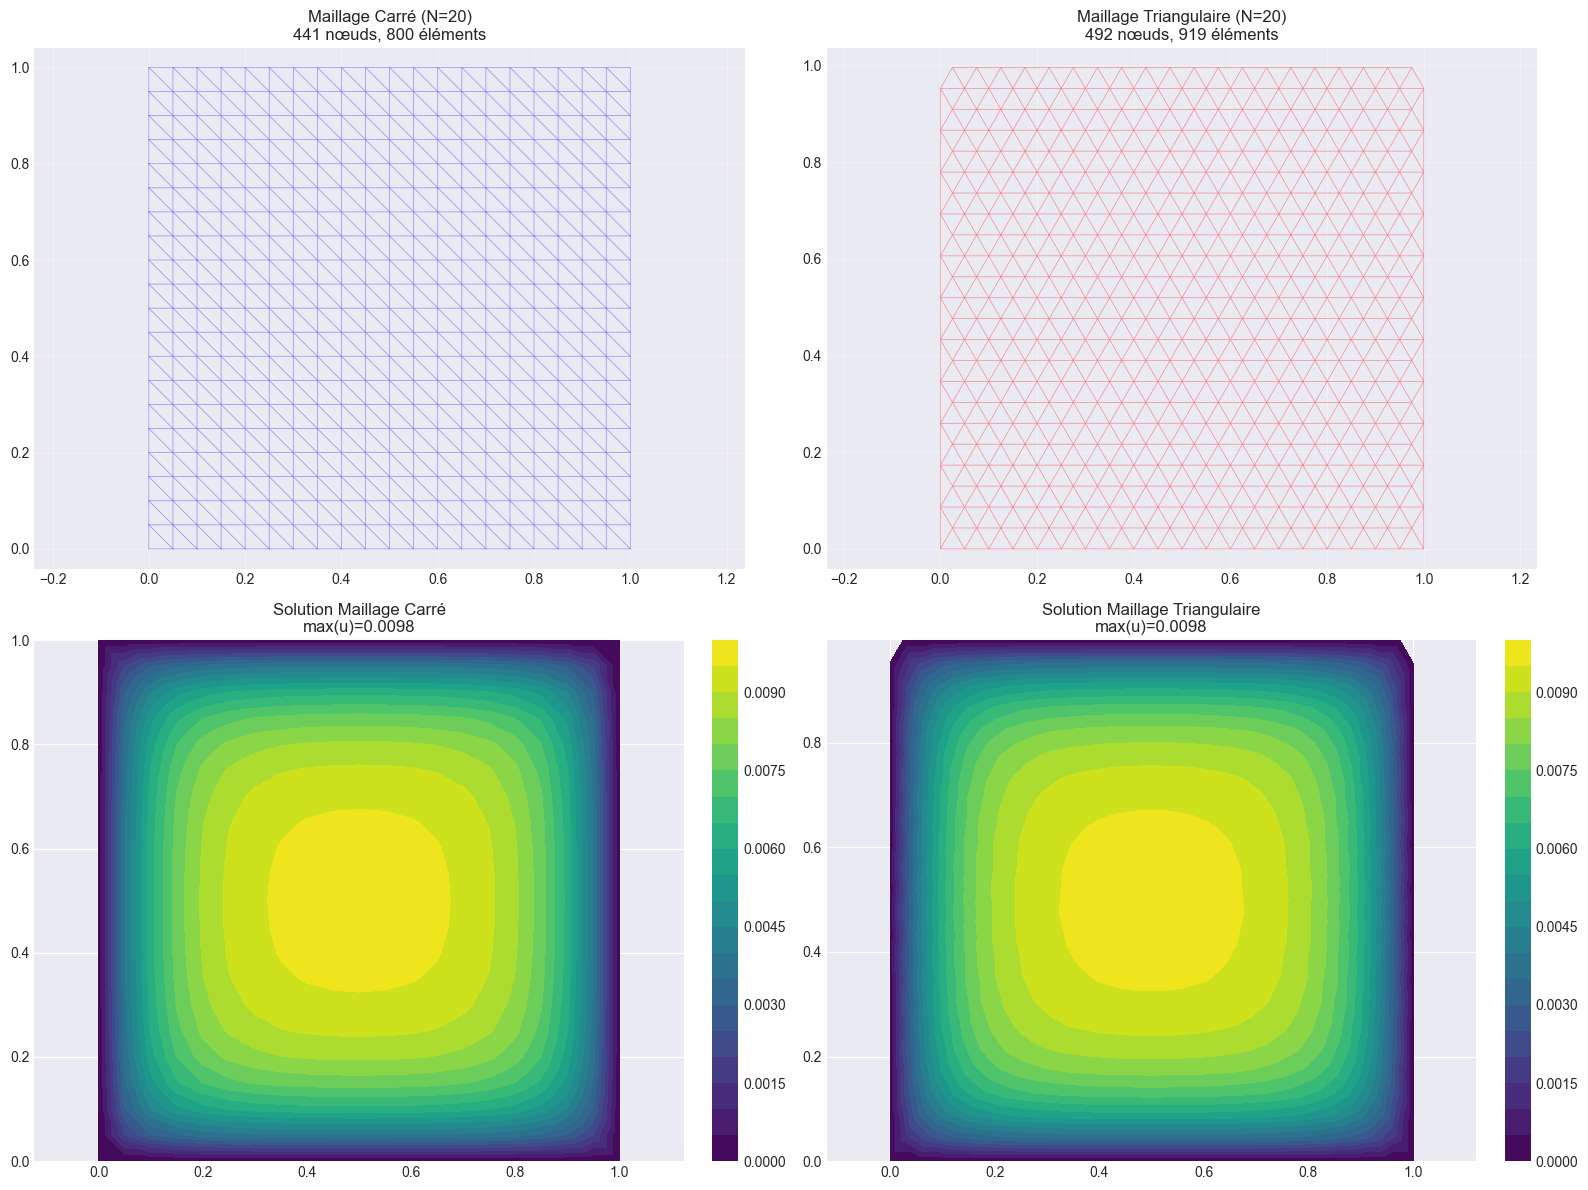


📈 Comparaison des maillages:
Maillage carré:       441 nœuds,  800 éléments, max(u)=0.009759
Maillage triangulaire:  492 nœuds,  919 éléments, max(u)=0.009751
Différence relative: 0.08%


In [25]:
# Comparaison directe à résolution équivalente
N = 20
kappa = 10
f_val = 1

# Maillage carré
square_mesh = SquareMesh(N).build()
square_solver = FEMSolver(square_mesh, kappa=kappa, f_val=f_val)
square_solution = square_solver.solve()

# Maillage triangulaire
tri_mesh = EquilateralMesh(N).build()
tri_solver = FEMSolver(tri_mesh, kappa=kappa, f_val=f_val)
tri_solution = tri_solver.solve()

# Comparaison visuelle
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Maillages
square_tri = Triangulation(square_mesh.nodes[:, 0], square_mesh.nodes[:, 1], square_mesh.elements)
ax1.triplot(square_tri, 'b-', alpha=0.4, linewidth=0.5)
ax1.set_title(f'Maillage Carré (N={N})\n{len(square_mesh.nodes)} nœuds, {len(square_mesh.elements)} éléments')
ax1.axis('equal')
ax1.grid(True, alpha=0.3)

triangular_tri = Triangulation(tri_mesh.nodes[:, 0], tri_mesh.nodes[:, 1], tri_mesh.elements)
ax2.triplot(triangular_tri, 'r-', alpha=0.4, linewidth=0.5)
ax2.set_title(f'Maillage Triangulaire (N={N})\n{len(tri_mesh.nodes)} nœuds, {len(tri_mesh.elements)} éléments')
ax2.axis('equal')
ax2.grid(True, alpha=0.3)

# Solutions
im1 = ax3.tricontourf(square_tri, square_solution, levels=20, cmap='viridis')
ax3.set_title(f'Solution Maillage Carré\nmax(u)={np.max(square_solution):.4f}')
ax3.axis('equal')
plt.colorbar(im1, ax=ax3, fraction=0.046, pad=0.04)

im2 = ax4.tricontourf(triangular_tri, tri_solution, levels=20, cmap='viridis')
ax4.set_title(f'Solution Maillage Triangulaire\nmax(u)={np.max(tri_solution):.4f}')
ax4.axis('equal')
plt.colorbar(im2, ax=ax4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Statistiques comparatives
print("\n📈 Comparaison des maillages:")
print(f"Maillage carré:      {len(square_mesh.nodes):4d} nœuds, {len(square_mesh.elements):4d} éléments, max(u)={np.max(square_solution):.6f}")
print(f"Maillage triangulaire: {len(tri_mesh.nodes):4d} nœuds, {len(tri_mesh.elements):4d} éléments, max(u)={np.max(tri_solution):.6f}")
print(f"Différence relative: {abs(np.max(square_solution) - np.max(tri_solution))/np.max(square_solution)*100:.2f}%")

## 4. Obstacles intégrés

### Obstacles carrés (maillages carrés)

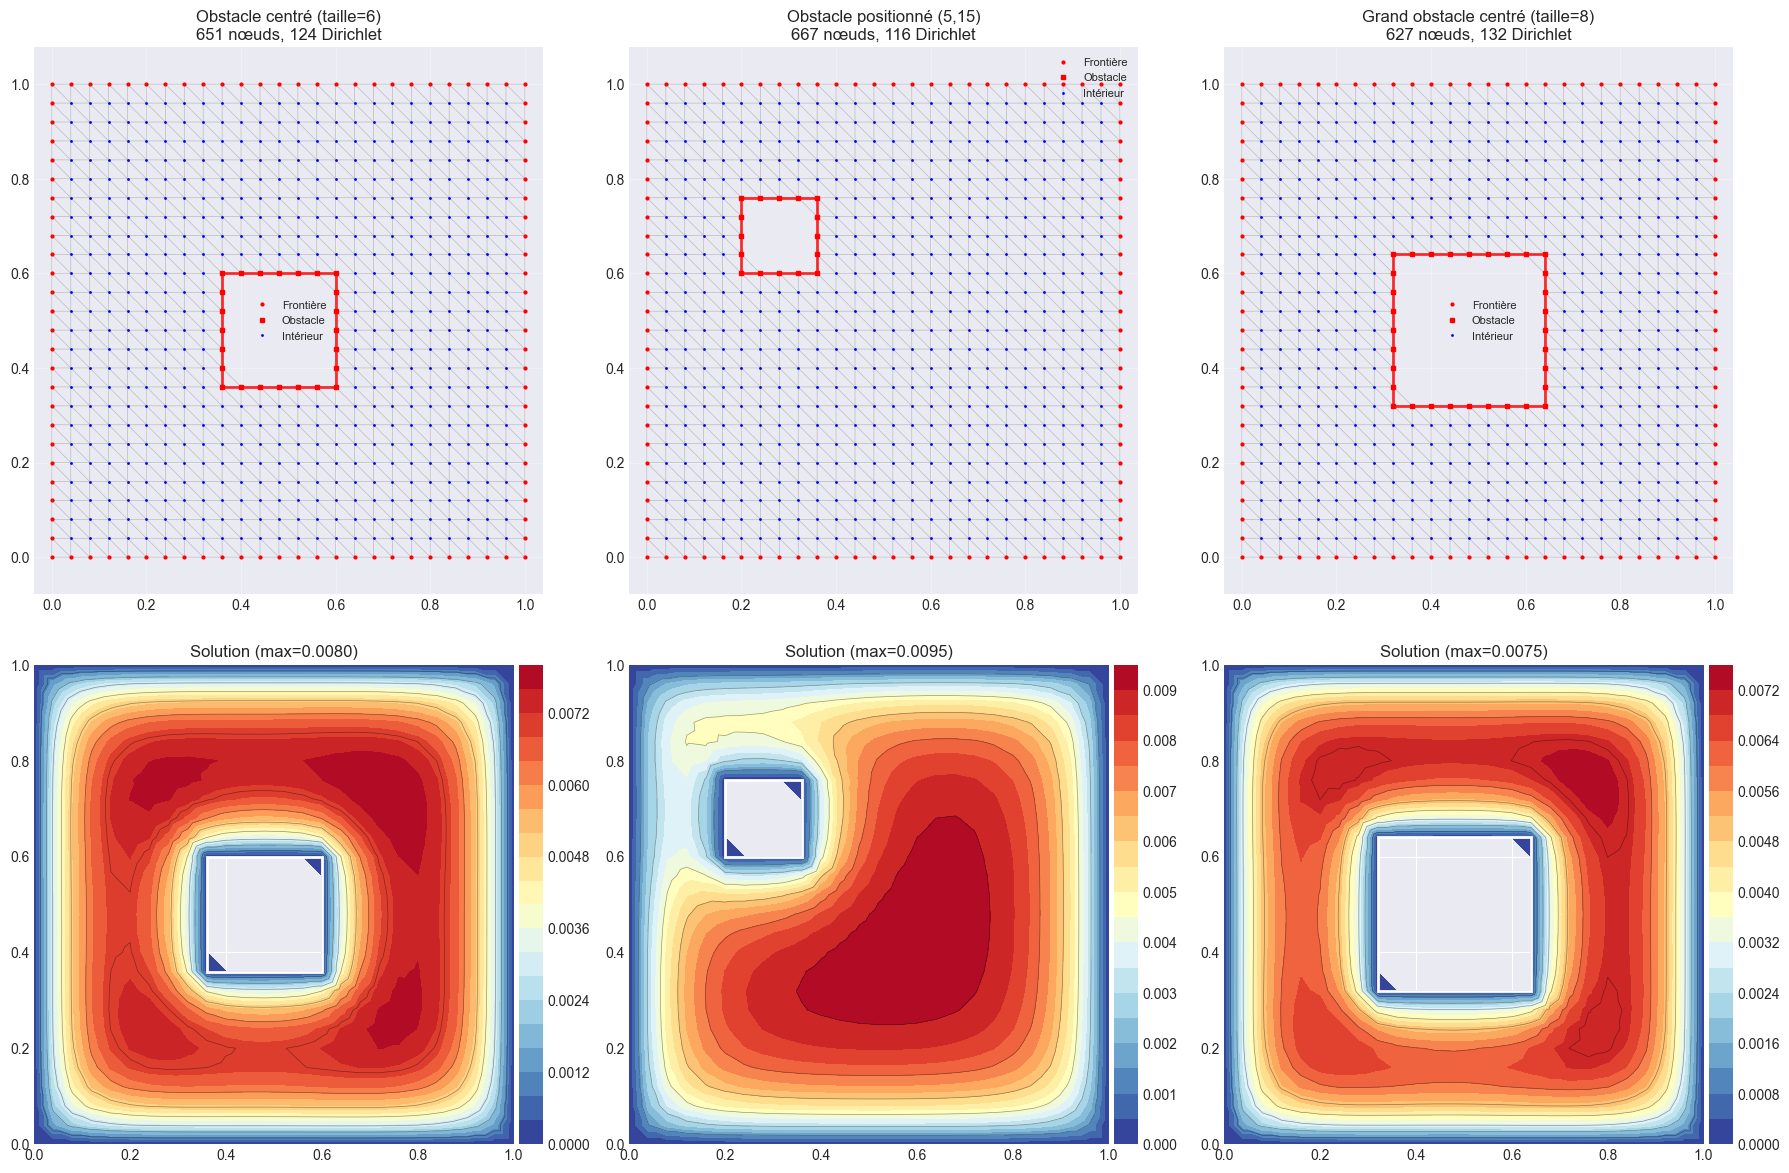

In [27]:
# Import des nouvelles fonctions d'obstacles alignés
from src.mesh_square import create_square_obstacle, create_square_obstacle_at_position

def plot_squared_obstacles():
    N = 25
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    
    # Exemple 1: Obstacle centré automatiquement
    obstacle1 = create_square_obstacle(N, obstacle_size=6)
    mesh1 = SquareMesh(N, obstacle=obstacle1).build()
    solver1 = FEMSolver(mesh1, kappa=10, f_val=1)
    sol1 = solver1.solve()
    
    # Exemple 2: Obstacle à une position spécifique
    obstacle2 = create_square_obstacle_at_position(N, obstacle_size=4, corner_i=5, corner_j=15)
    mesh2 = SquareMesh(N, obstacle=obstacle2).build()
    solver2 = FEMSolver(mesh2, kappa=10, f_val=1)
    sol2 = solver2.solve()
    
    # Exemple 3: Petit obstacle centré
    obstacle3 = create_square_obstacle(N, obstacle_size=8)
    mesh3 = SquareMesh(N, obstacle=obstacle3).build()
    solver3 = FEMSolver(mesh3, kappa=10, f_val=1)
    sol3 = solver3.solve()
    
    # Configurations pour visualisation
    configs = [
        (mesh1, sol1, obstacle1, "Obstacle centré (taille=6)"),
        (mesh2, sol2, obstacle2, "Obstacle positionné (5,15)"),
        (mesh3, sol3, obstacle3, "Grand obstacle centré (taille=8)")
    ]
    
    for i, (mesh, sol, obs, title) in enumerate(configs):
        # Maillage (ligne du haut)
        tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
        axes[0, i].triplot(tri, 'k-', alpha=0.2, linewidth=0.5)
        
        # Coloration des nœuds
        boundary_nodes = mesh.is_dirichlet & ((mesh.nodes[:, 0] <= 1e-10) | (mesh.nodes[:, 0] >= 1-1e-10) | 
                                              (mesh.nodes[:, 1] <= 1e-10) | (mesh.nodes[:, 1] >= 1-1e-10))
        obstacle_nodes = mesh.is_dirichlet & ~boundary_nodes
        interior_nodes = ~mesh.is_dirichlet
        
        axes[0, i].plot(mesh.nodes[boundary_nodes, 0], mesh.nodes[boundary_nodes, 1], 
                       'ro', markersize=2, label='Frontière')
        axes[0, i].plot(mesh.nodes[obstacle_nodes, 0], mesh.nodes[obstacle_nodes, 1], 
                       'rs', markersize=3, label='Obstacle')
        axes[0, i].plot(mesh.nodes[interior_nodes, 0], mesh.nodes[interior_nodes, 1], 
                       'bo', markersize=1, label='Intérieur')
        
        # Rectangle de l'obstacle
        x0, y0, m = obs['x0'], obs['y0'], obs['m']
        size = m / N
        rect = patches.Rectangle((x0, y0), size, size, 
                               linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        axes[0, i].add_patch(rect)
        
        axes[0, i].set_title(f'{title}\n{len(mesh.nodes)} nœuds, {np.sum(mesh.is_dirichlet)} Dirichlet')
        axes[0, i].axis('equal')
        axes[0, i].legend(fontsize=8)
        axes[0, i].grid(True, alpha=0.3)
        
        # Solution (ligne du bas)
        im = axes[1, i].tricontourf(tri, sol, levels=20, cmap='RdYlBu_r')
        axes[1, i].tricontour(tri, sol, levels=8, colors='black', alpha=0.4, linewidths=0.5)
        
        # Rectangle de l'obstacle sur la solution
        rect2 = patches.Rectangle((x0, y0), size, size, 
                                linewidth=2, edgecolor='white', facecolor='none')
        axes[1, i].add_patch(rect2)
        
        axes[1, i].set_title(f'Solution (max={np.max(sol):.4f})')
        axes[1, i].axis('equal')
        
        # Barre de couleur
        divider = make_axes_locatable(axes[1, i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(im, cax=cax)
    
    plt.tight_layout()
    return fig

# Démonstration des obstacles alignés
plot_squared_obstacles()
plt.show()



### Obstacles circulaires (maillages triangulaires)

🔴 Obstacles circulaires avec différentes tailles


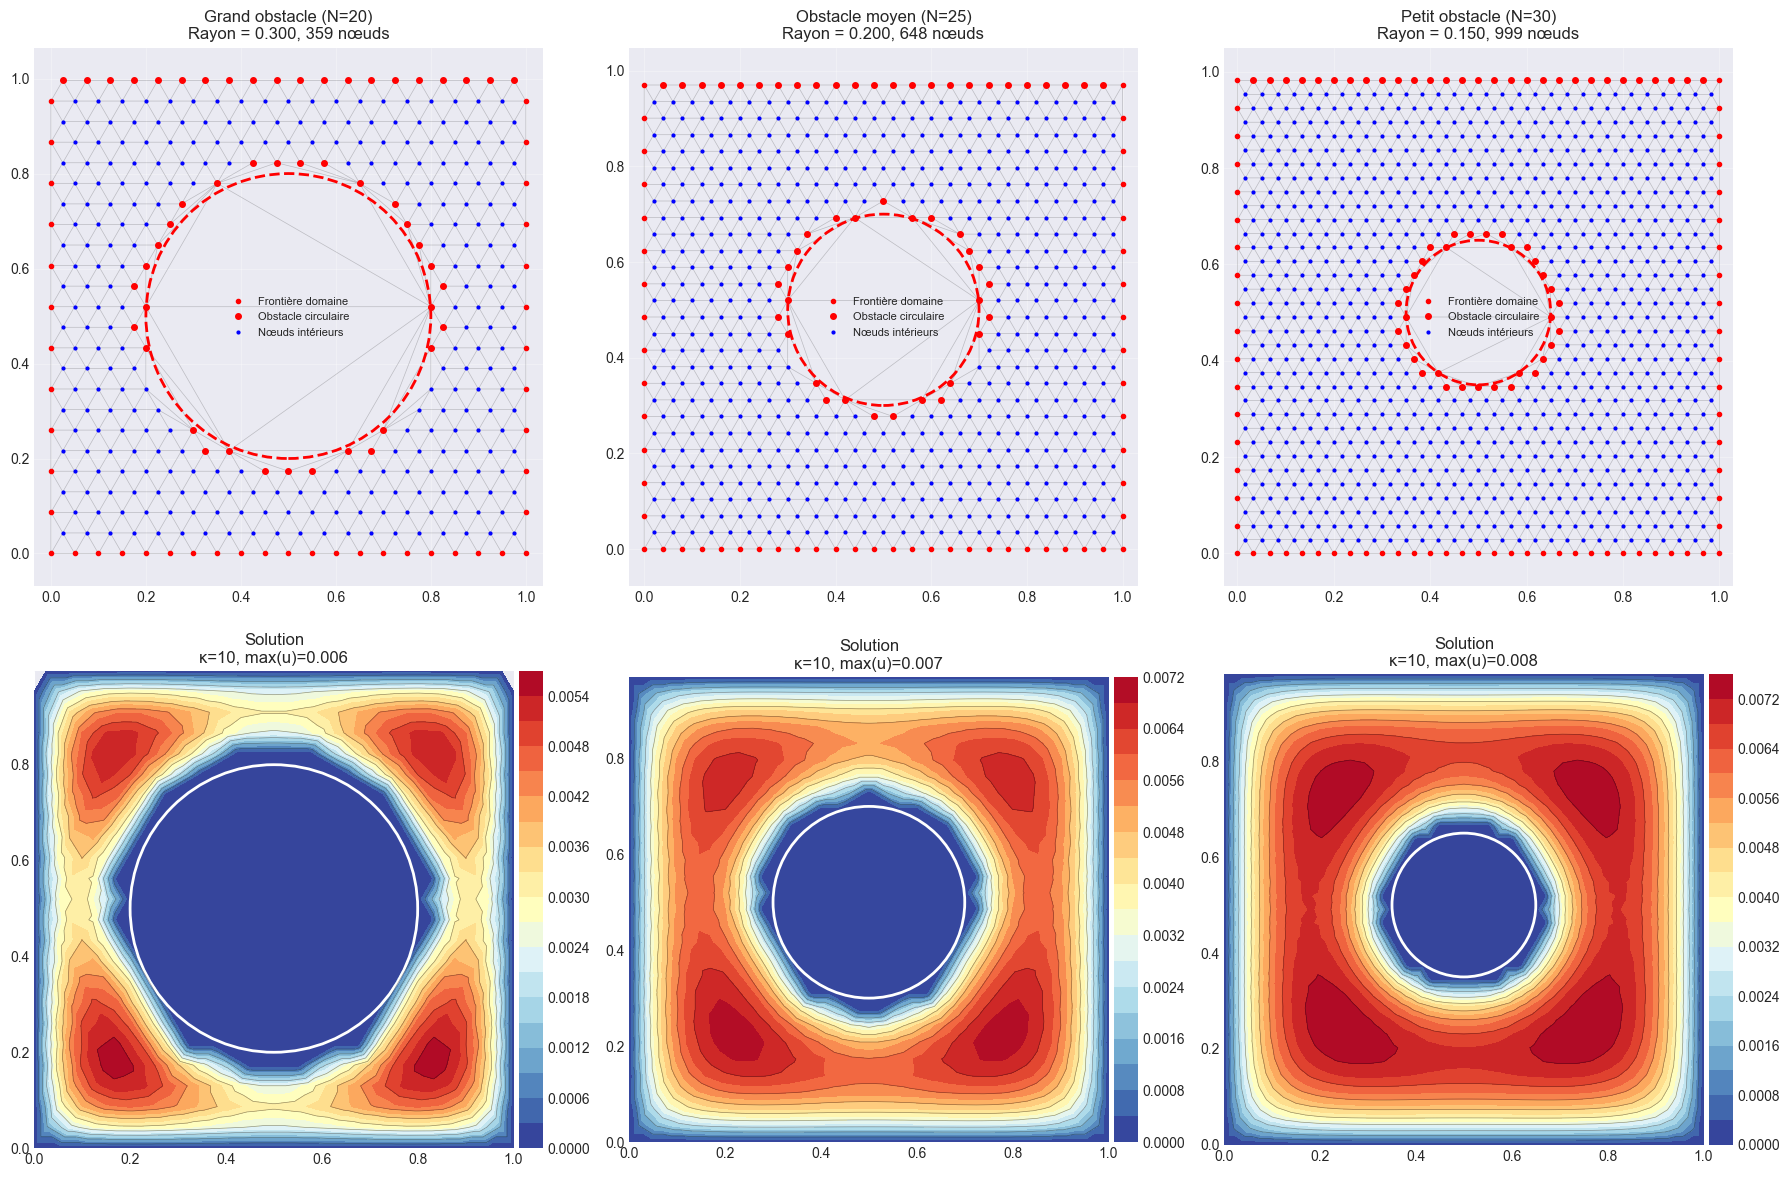

In [30]:
def visualize_disk_obstacle(N, radius, kappa=10, f_val=1):
    """Visualise un maillage triangulaire avec obstacle circulaire"""
    # Génération du maillage avec obstacle
    obstacle = {'type': 'disk', 'r': radius}
    mesh = EquilateralMesh(N, obstacle=obstacle).build()
    
    # Résolution
    solver = FEMSolver(mesh, kappa=kappa, f_val=f_val)
    solution = solver.solve()
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Maillage avec obstacle
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    ax1.triplot(tri, 'k-', alpha=0.2, linewidth=0.5)
    
    # Identification des types de nœuds
    center = np.array([0.5, 0.5])
    distances = np.linalg.norm(mesh.nodes - center, axis=1)
    
    boundary_nodes = mesh.is_dirichlet & ((mesh.nodes[:, 0] <= 1e-10) | (mesh.nodes[:, 0] >= 1-1e-10) | 
                                          (mesh.nodes[:, 1] <= 1e-10) | (mesh.nodes[:, 1] >= 1-1e-10))
    obstacle_nodes = mesh.is_dirichlet & ~boundary_nodes
    interior_nodes = ~mesh.is_dirichlet
    
    ax1.plot(mesh.nodes[boundary_nodes, 0], mesh.nodes[boundary_nodes, 1], 
             'ro', markersize=3, label='Frontière domaine')
    ax1.plot(mesh.nodes[obstacle_nodes, 0], mesh.nodes[obstacle_nodes, 1], 
             'ro', markersize=4, label='Obstacle circulaire')
    ax1.plot(mesh.nodes[interior_nodes, 0], mesh.nodes[interior_nodes, 1], 
             'bo', markersize=2, label='Nœuds intérieurs')
    
    # Cercle de l'obstacle
    circle = patches.Circle(center, radius, linewidth=2, edgecolor='red', 
                          facecolor='none', linestyle='--')
    ax1.add_patch(circle)
    
    ax1.set_title(f'Maillage avec obstacle circulaire (N={N})\nRayon = {radius:.3f}')
    ax1.legend()
    ax1.axis('equal')
    ax1.grid(True, alpha=0.3)
    
    # Solution
    im = ax2.tricontourf(tri, solution, levels=20, cmap='RdYlBu_r')
    ax2.tricontour(tri, solution, levels=10, colors='black', alpha=0.4, linewidths=0.5)
    
    # Cercle de l'obstacle sur la solution
    circle2 = patches.Circle(center, radius, linewidth=2, edgecolor='white', facecolor='none')
    ax2.add_patch(circle2)
    
    ax2.set_title(f'Solution avec obstacle circulaire\nκ={kappa}, f={f_val}')
    ax2.axis('equal')
    
    # Barre de couleur
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.tight_layout()
    return fig, solution

# Exemples d'obstacles circulaires dans un seul graphique
N_values = [20, 25, 30]
radius_values = [0.3, 0.2, 0.15]
kappa = 10
titles = ["Grand obstacle", "Obstacle moyen", "Petit obstacle"]

print("🔴 Obstacles circulaires avec différentes tailles")

# Création du graphique avec 2 lignes et 3 colonnes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (N, radius, title) in enumerate(zip(N_values, radius_values, titles)):
    # Génération du maillage avec obstacle
    obstacle = {'type': 'disk', 'r': radius}
    mesh = EquilateralMesh(N, obstacle=obstacle).build()
    
    # Résolution
    solver = FEMSolver(mesh, kappa=kappa, f_val=1)
    solution = solver.solve()
    
    # Triangulation pour visualisation
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    center = np.array([0.5, 0.5])
    
    # Première ligne : Maillages avec obstacles
    axes[0, i].triplot(tri, 'k-', alpha=0.2, linewidth=0.5)
    
    # Identification des types de nœuds
    boundary_nodes = mesh.is_dirichlet & ((mesh.nodes[:, 0] <= 1e-10) | (mesh.nodes[:, 0] >= 1-1e-10) | 
                                          (mesh.nodes[:, 1] <= 1e-10) | (mesh.nodes[:, 1] >= 1-1e-10))
    obstacle_nodes = mesh.is_dirichlet & ~boundary_nodes
    interior_nodes = ~mesh.is_dirichlet
    
    axes[0, i].plot(mesh.nodes[boundary_nodes, 0], mesh.nodes[boundary_nodes, 1], 
                    'ro', markersize=3, label='Frontière domaine')
    axes[0, i].plot(mesh.nodes[obstacle_nodes, 0], mesh.nodes[obstacle_nodes, 1], 
                    'ro', markersize=4, label='Obstacle circulaire')
    axes[0, i].plot(mesh.nodes[interior_nodes, 0], mesh.nodes[interior_nodes, 1], 
                    'bo', markersize=2, label='Nœuds intérieurs')
    
    # Cercle de l'obstacle
    circle = patches.Circle(center, radius, linewidth=2, edgecolor='red', 
                          facecolor='none', linestyle='--')
    axes[0, i].add_patch(circle)
    
    axes[0, i].set_title(f'{title} (N={N})\nRayon = {radius:.3f}, {len(mesh.nodes)} nœuds')
    axes[0, i].legend(fontsize=8)
    axes[0, i].axis('equal')
    axes[0, i].grid(True, alpha=0.3)
    
    # Deuxième ligne : Solutions
    im = axes[1, i].tricontourf(tri, solution, levels=20, cmap='RdYlBu_r')
    axes[1, i].tricontour(tri, solution, levels=10, colors='black', alpha=0.4, linewidths=0.5)
    
    # Cercle de l'obstacle sur la solution
    circle2 = patches.Circle(center, radius, linewidth=2, edgecolor='white', facecolor='none')
    axes[1, i].add_patch(circle2)
    
    axes[1, i].set_title(f'Solution\nκ={kappa}, max(u)={np.max(solution):.3f}')
    axes[1, i].axis('equal')
    
    # Barre de couleur
    divider = make_axes_locatable(axes[1, i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

## 5. Comparaisons et analyses 

Comparaisons entre différentes configurations.

🔄 Comparaison: impact des obstacles


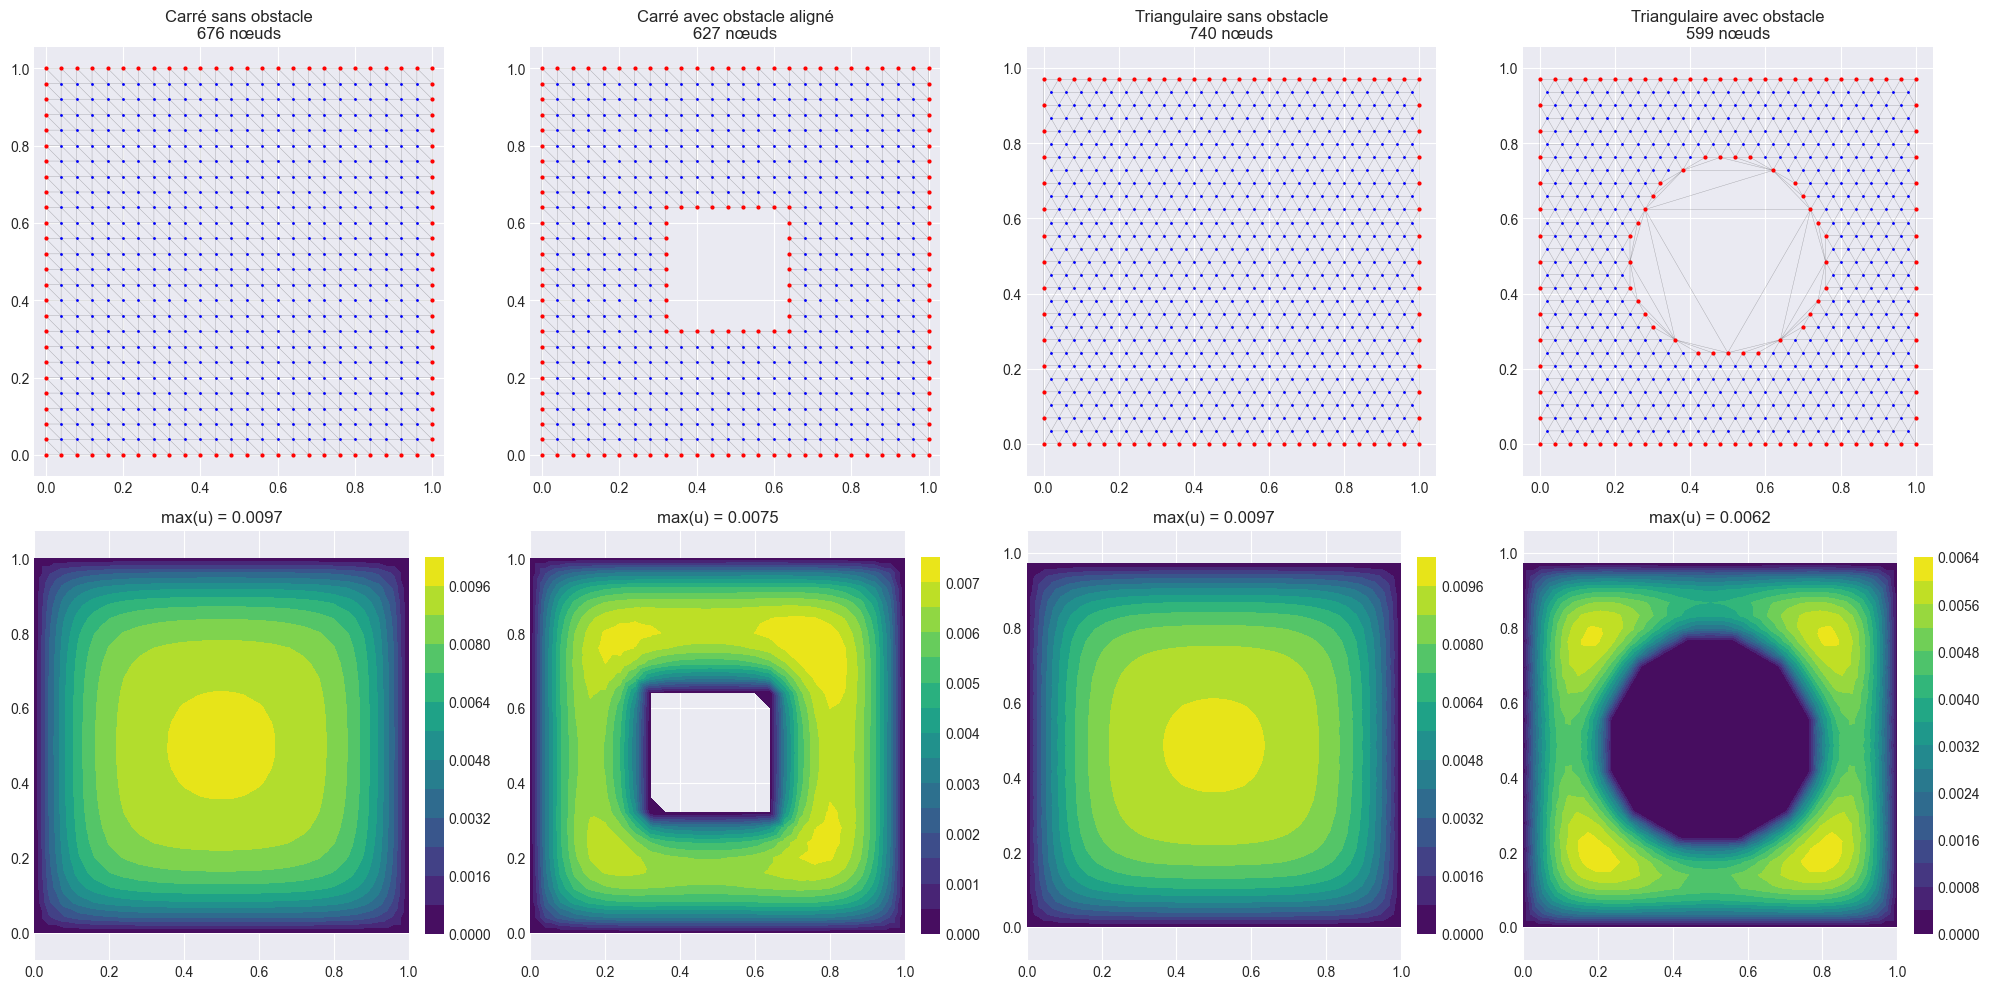


📊 Statistiques comparatives:
Carré sans obstacle      :  676 nœuds (576 int.), 1250 éléments, max(u)=0.009750
Carré avec obstacle aligné:  627 nœuds (495 int.), 1124 éléments, max(u)=0.007460
Triangulaire sans obstacle:  740 nœuds (662 int.), 1400 éléments, max(u)=0.009731
Triangulaire avec obstacle:  599 nœuds (488 int.), 1118 éléments, max(u)=0.006199


In [32]:
# Comparaison: avec et sans obstacles
N = 25
kappa = 10
f_val = 1

print("🔄 Comparaison: impact des obstacles")

# Configuration 1: Maillage carré sans obstacle
mesh1 = SquareMesh(N).build()
solver1 = FEMSolver(mesh1, kappa=kappa, f_val=f_val)
sol1 = solver1.solve()

# Configuration 2: Maillage carré avec obstacle carré
obstacle_square = create_square_obstacle(N, obstacle_size=8)
mesh2 = SquareMesh(N, obstacle=obstacle_square).build()
solver2 = FEMSolver(mesh2, kappa=kappa, f_val=f_val)
sol2 = solver2.solve()

# Configuration 3: Maillage triangulaire sans obstacle
mesh3 = EquilateralMesh(N).build()
solver3 = FEMSolver(mesh3, kappa=kappa, f_val=f_val)
sol3 = solver3.solve()

# Configuration 4: Maillage triangulaire avec obstacle circulaire
obstacle_disk = {'type': 'disk', 'r': 0.25}
mesh4 = EquilateralMesh(N, obstacle=obstacle_disk).build()
solver4 = FEMSolver(mesh4, kappa=kappa, f_val=f_val)
sol4 = solver4.solve()

# Visualisation comparative
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

configs = [
    (mesh1, sol1, "Carré sans obstacle"),
    (mesh2, sol2, "Carré avec obstacle aligné"),
    (mesh3, sol3, "Triangulaire sans obstacle"),
    (mesh4, sol4, "Triangulaire avec obstacle")
]

for i, (mesh, sol, title) in enumerate(configs):
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    # Maillages (ligne du haut)
    axes[0, i].triplot(tri, 'k-', alpha=0.3, linewidth=0.3)
    axes[0, i].plot(mesh.nodes[mesh.is_dirichlet, 0], mesh.nodes[mesh.is_dirichlet, 1], 
                    'ro', markersize=2)
    axes[0, i].plot(mesh.nodes[~mesh.is_dirichlet, 0], mesh.nodes[~mesh.is_dirichlet, 1], 
                    'bo', markersize=1)
    axes[0, i].set_title(f'{title}\n{len(mesh.nodes)} nœuds')
    axes[0, i].axis('equal')
    axes[0, i].set_aspect('equal')
    
    # Solutions (ligne du bas)
    im = axes[1, i].tricontourf(tri, sol, levels=15, cmap='viridis')
    axes[1, i].set_title(f'max(u) = {np.max(sol):.4f}')
    axes[1, i].axis('equal')
    axes[1, i].set_aspect('equal')
    
    # Barre de couleur
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Statistiques
print("\n📊 Statistiques comparatives:")
for i, (mesh, sol, title) in enumerate(configs):
    interior_nodes = np.sum(~mesh.is_dirichlet)
    print(f"{title:25s}: {len(mesh.nodes):4d} nœuds ({interior_nodes:3d} int.), "
          f"{len(mesh.elements):4d} éléments, max(u)={np.max(sol):.6f}")

### Influence du paramètre κ (fréquence)

🌊 Influence du paramètre κ (fréquence)


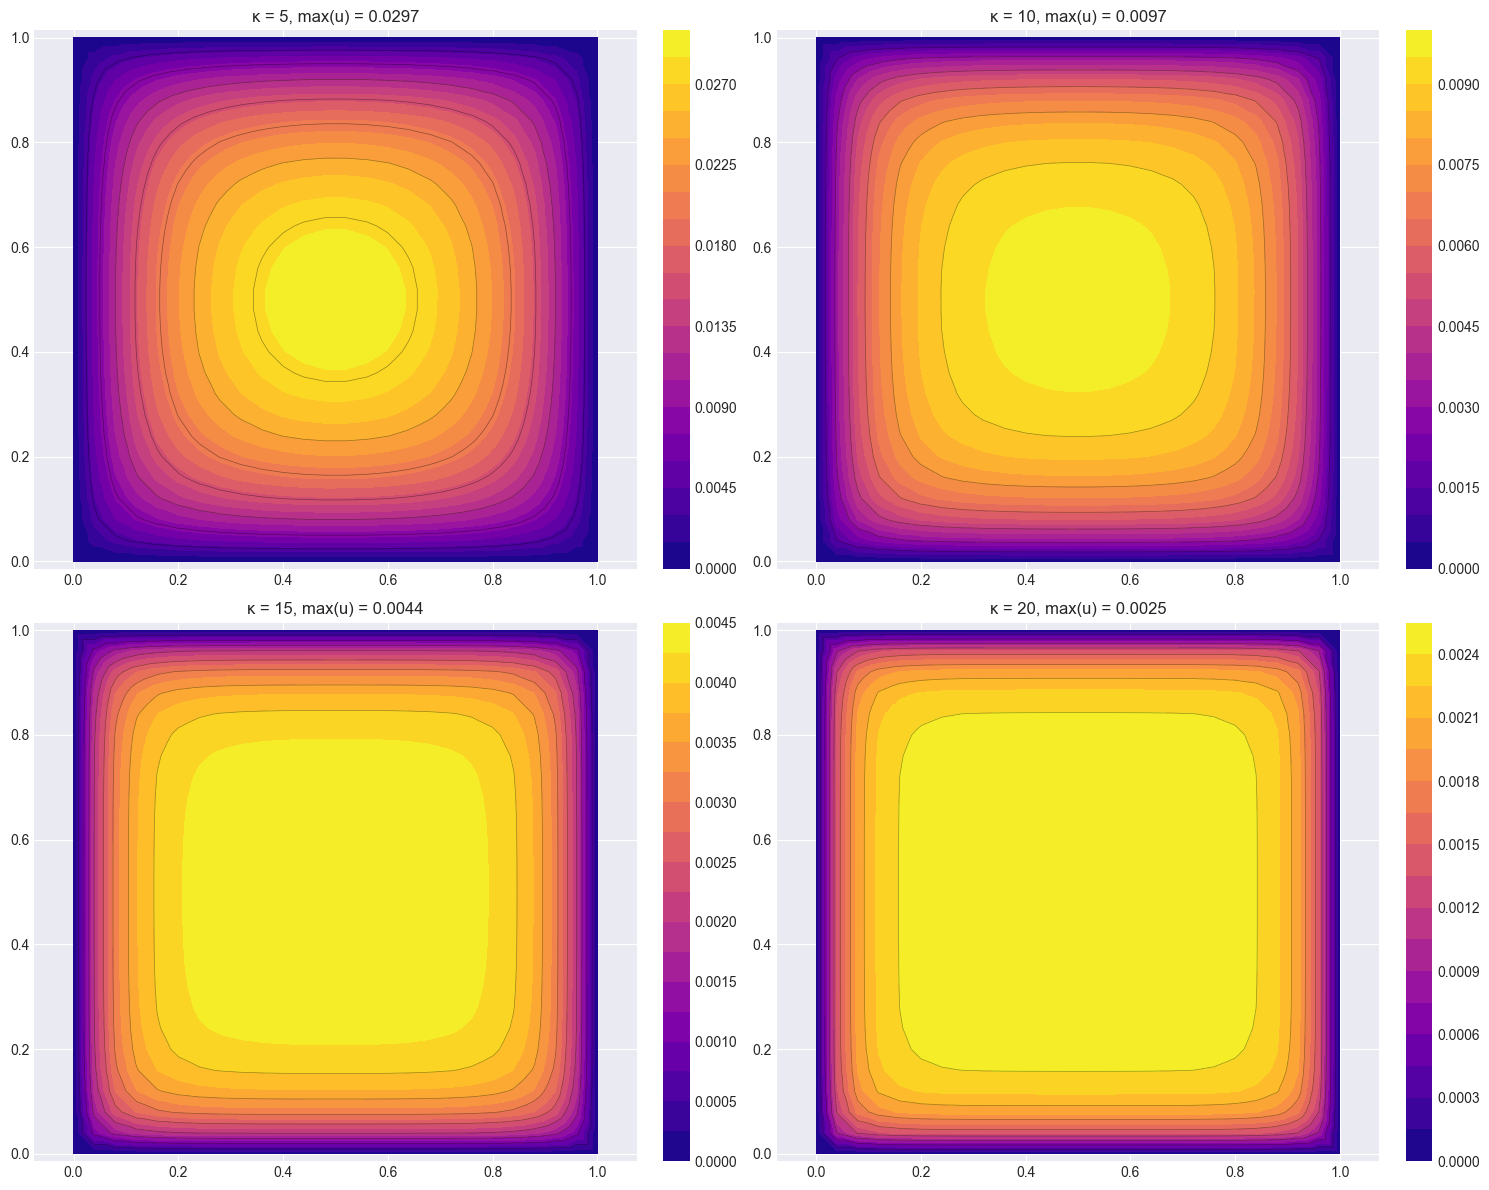

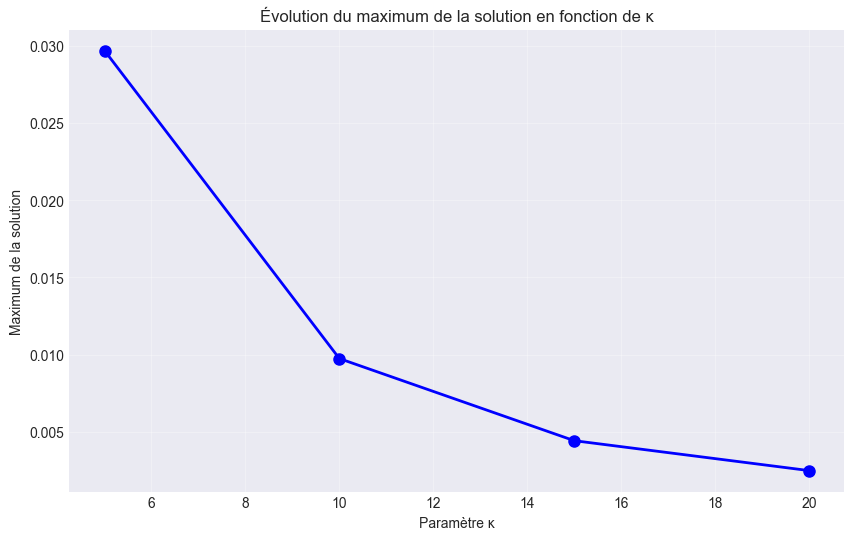


📈 Évolution: κ varie de 5 à 20
   max(u) varie de 0.029683 à 0.002500


In [34]:
# Étude de l'influence du paramètre kappa
N = 25
f_val = 1
kappa_values = [5, 10, 15, 20]

print("🌊 Influence du paramètre κ (fréquence)")

# Maillage de base
mesh = SquareMesh(N).build()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

max_values = []
for i, kappa in enumerate(kappa_values):
    solver = FEMSolver(mesh, kappa=kappa, f_val=f_val)
    solution = solver.solve()
    max_values.append(np.max(solution))
    
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    im = axes[i].tricontourf(tri, solution, levels=20, cmap='plasma')
    axes[i].tricontour(tri, solution, levels=8, colors='black', alpha=0.4, linewidths=0.5)
    axes[i].set_title(f'κ = {kappa}, max(u) = {np.max(solution):.4f}')
    axes[i].axis('equal')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Graphique de l'évolution
plt.figure(figsize=(10, 6))
plt.plot(kappa_values, max_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Paramètre κ')
plt.ylabel('Maximum de la solution')
plt.title('Évolution du maximum de la solution en fonction de κ')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📈 Évolution: κ varie de {min(kappa_values)} à {max(kappa_values)}")
print(f"   max(u) varie de {max(max_values):.6f} à {min(max_values):.6f}")

## 6. Visualisations avancées

Créons quelques visualisations avancées et esthétiques.

🎨 Création d'une visualisation...


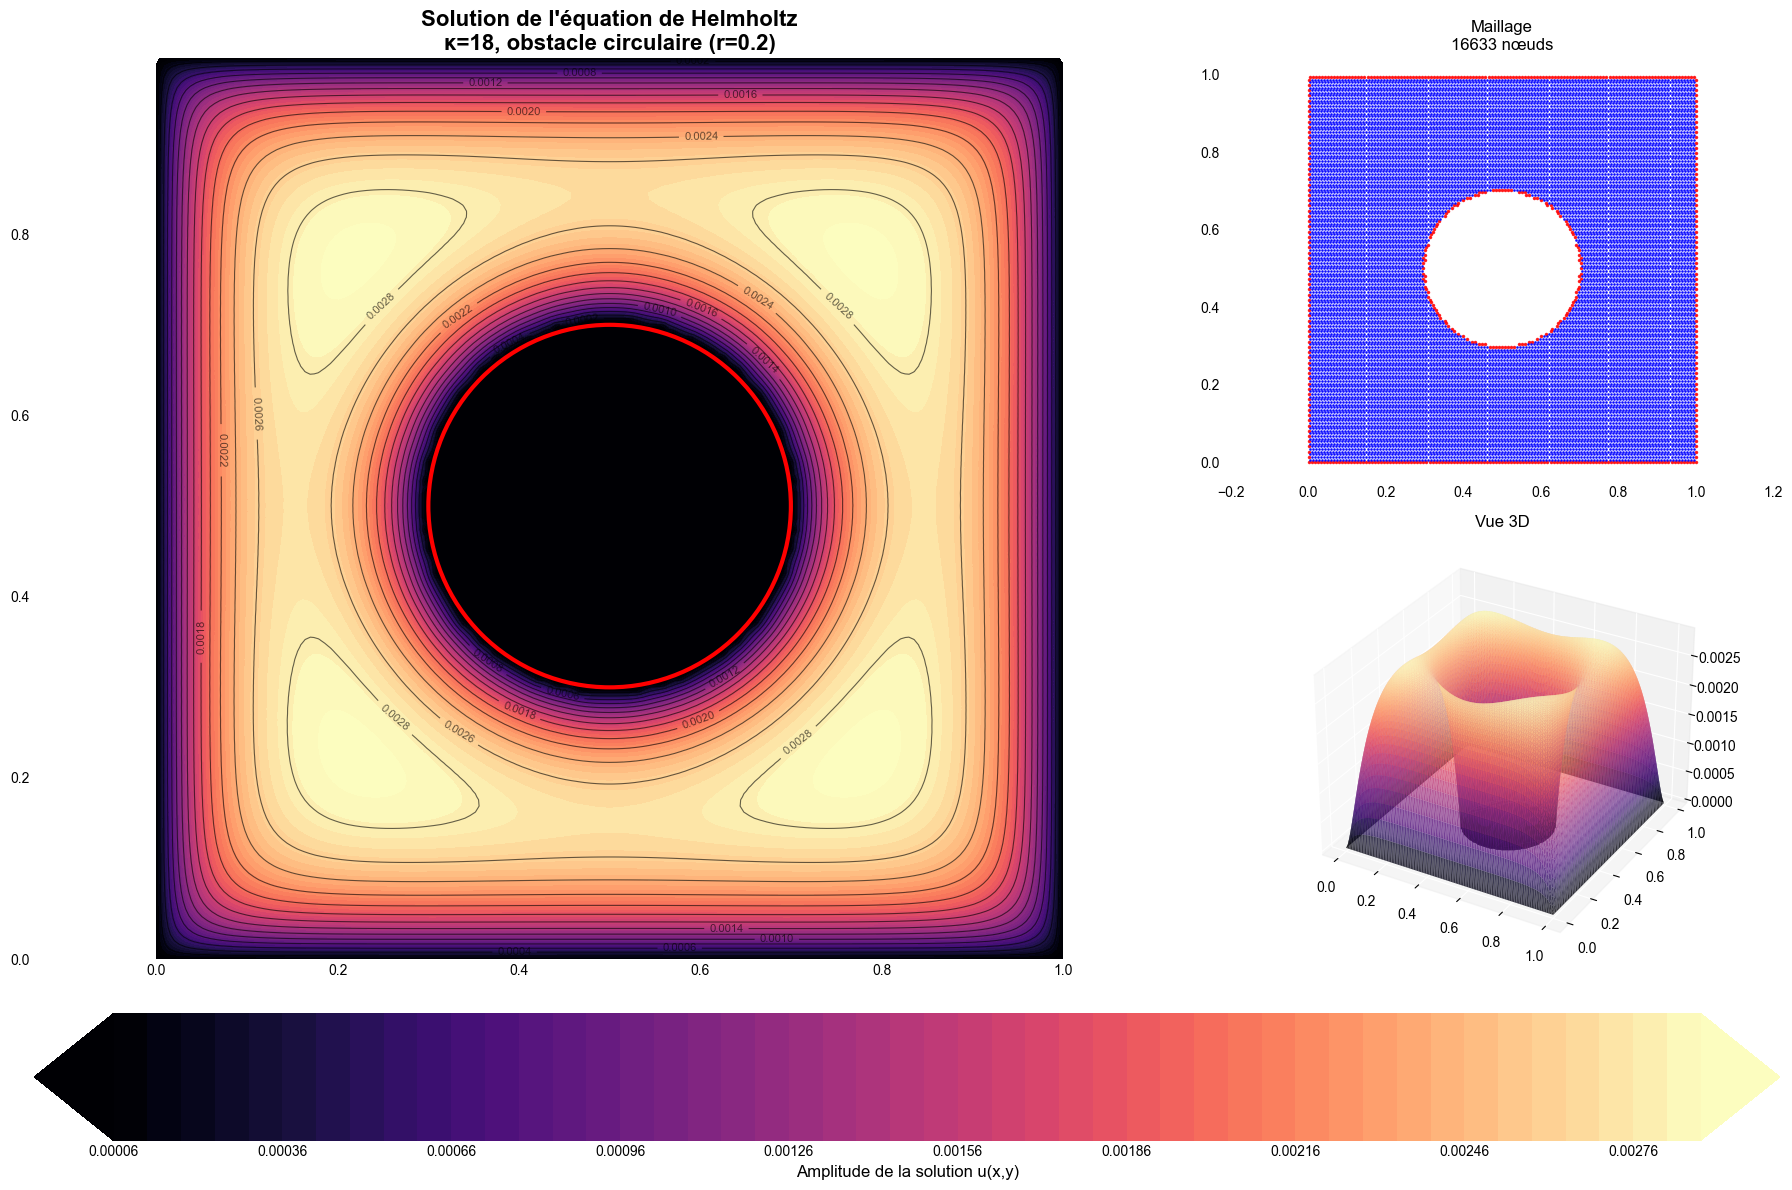


✨ Visualisation terminée!


In [38]:
def create_visualization():
    """Crée une visualisation"""
    
    # Configuration haute résolution
    N = 128
    kappa = 18
    f_val = 1
    
    # Maillage triangulaire avec obstacle circulaire
    obstacle = {'type': 'disk', 'r': 0.2}
    mesh = EquilateralMesh(N, obstacle=obstacle).build()
    solver = FEMSolver(mesh, kappa=kappa, f_val=f_val)
    solution = solver.solve()
    
    # Visualisation élégante
    fig = plt.figure(figsize=(18, 12))
    
    # Disposition complexe
    gs = fig.add_gridspec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 0.3])
    
    # Visualisation principale (grande)
    ax_main = fig.add_subplot(gs[:2, :2])
    tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
    
    # Solution avec couleurs élégantes
    im_main = ax_main.tricontourf(tri, solution, levels=50, cmap='magma', extend='both')
    contours = ax_main.tricontour(tri, solution, levels=15, colors='black', alpha=0.6, linewidths=0.8)
    ax_main.clabel(contours, inline=True, fontsize=8, colors='black')
    
    # Obstacle
    circle = patches.Circle([0.5, 0.5], 0.2, linewidth=3, edgecolor='red', 
                          facecolor='none')
    ax_main.add_patch(circle)
    
    ax_main.set_title(f'Solution de l\'équation de Helmholtz\nκ={kappa}, obstacle circulaire (r=0.2)', 
                     fontsize=16, fontweight='bold', color='black')
    ax_main.axis('equal')
    ax_main.set_facecolor('white')
    
    # Maillage détaillé (côté droit haut)
    ax_mesh = fig.add_subplot(gs[0, 2])
    # ax_mesh.triplot(tri, 'cyan', alpha=0.4, linewidth=0.3)
    ax_mesh.plot(mesh.nodes[mesh.is_dirichlet, 0], mesh.nodes[mesh.is_dirichlet, 1], 
                'ro', markersize=1.5, alpha=0.8)
    ax_mesh.plot(mesh.nodes[~mesh.is_dirichlet, 0], mesh.nodes[~mesh.is_dirichlet, 1], 
                'bo', markersize=1, alpha=0.8)
    ax_mesh.set_title(f'Maillage\n{len(mesh.nodes)} nœuds', fontsize=12, color='black')
    ax_mesh.axis('equal')
    ax_mesh.set_facecolor('white')
    
    # Vue 3D stylisée (côté droit bas)
    ax_3d = fig.add_subplot(gs[1, 2], projection='3d')
    x, y = mesh.nodes[:, 0], mesh.nodes[:, 1]
    ax_3d.plot_trisurf(x, y, solution, triangles=mesh.elements, cmap='magma', alpha=0.8)
    ax_3d.set_title('Vue 3D', fontsize=12, color='black')
    ax_3d.set_facecolor('white')
    
    # Barre de couleur élégante
    cbar_ax = fig.add_subplot(gs[2, :])
    cbar = plt.colorbar(im_main, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Amplitude de la solution u(x,y)', fontsize=12, color='black')
    cbar.ax.tick_params(colors='black')
    
    # Style général
    fig.patch.set_facecolor('white')
    for ax in [ax_main, ax_mesh, ax_3d]:
        ax.tick_params(colors='black')
        for spine in ax.spines.values():
            spine.set_color('black')
    
    plt.tight_layout()
    return fig

print("🎨 Création d'une visualisation...")
showcase_fig = create_visualization()
plt.show()

print("\n✨ Visualisation terminée!")

### Galerie de solutions avec paramètres variés

🖼️ Création d'une galerie de solutions avec obstacles alignés...


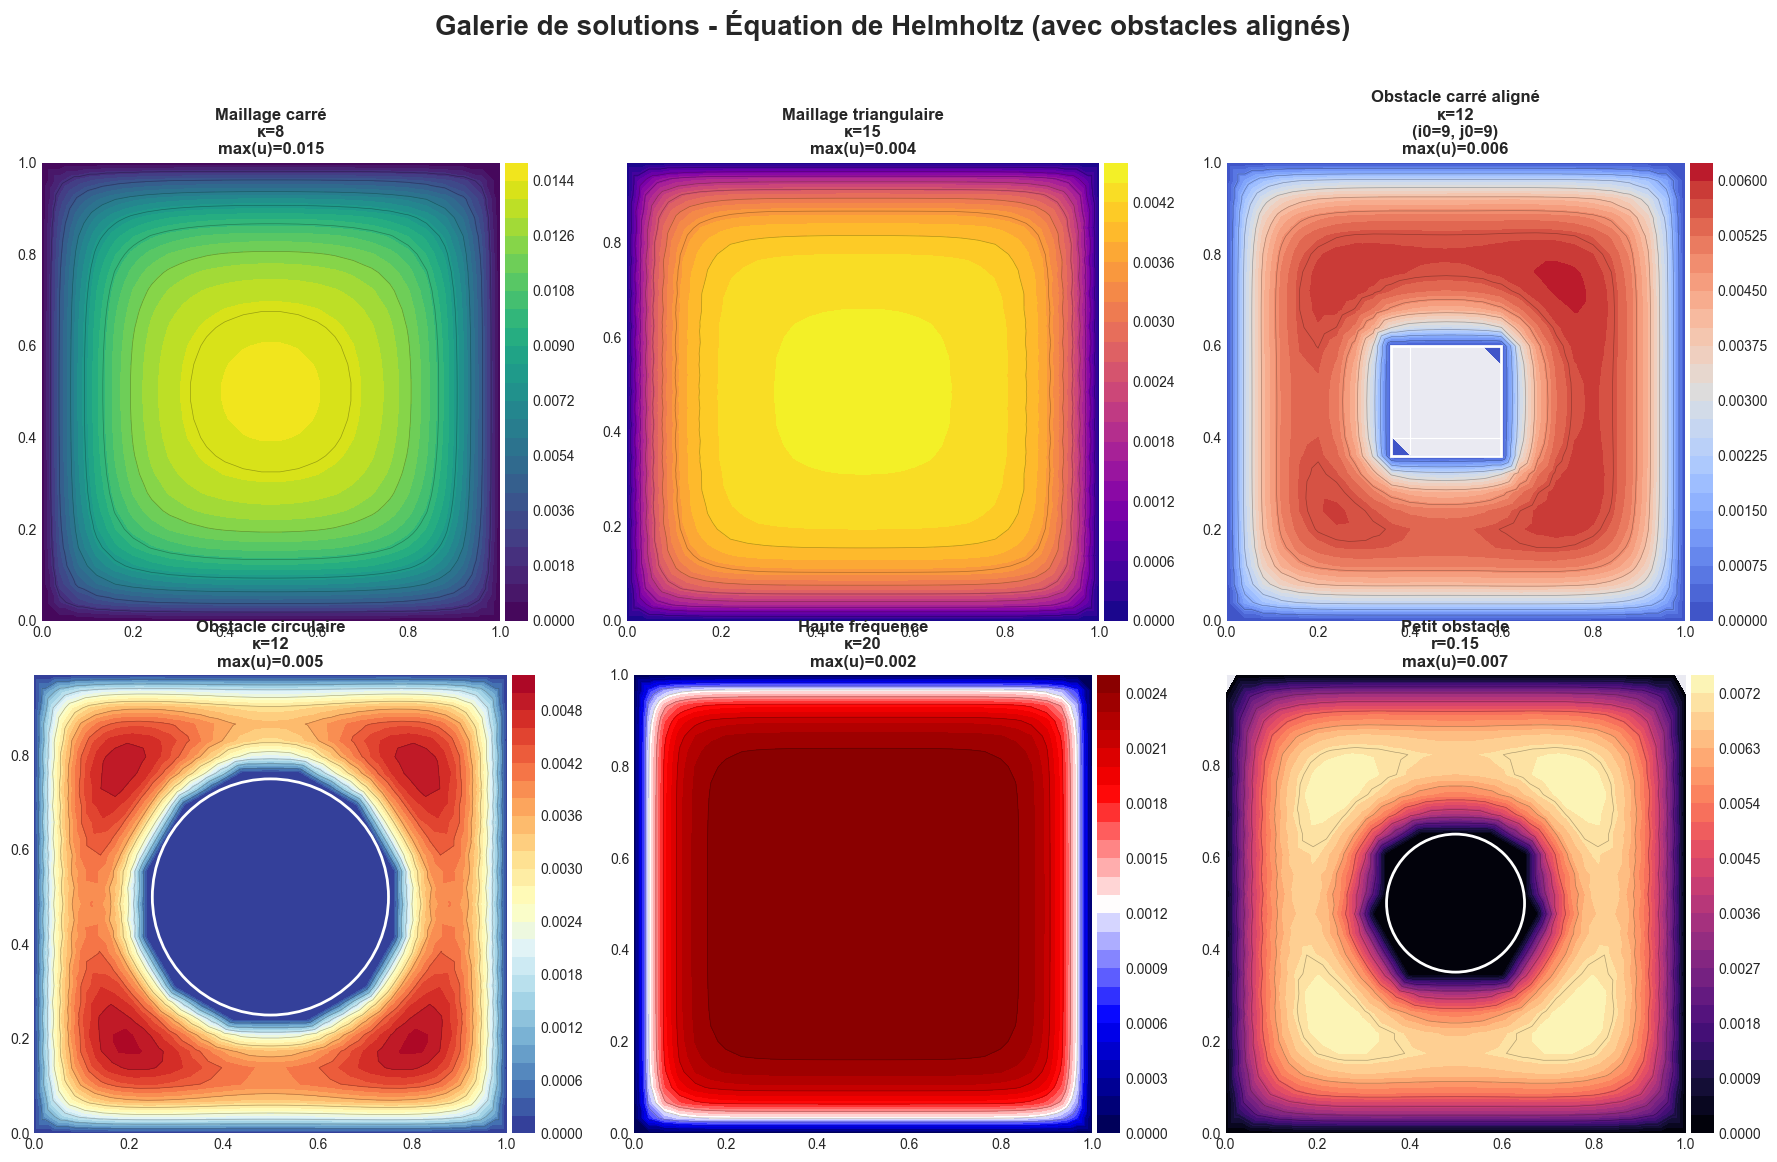


🎯 Galerie terminée!

📝 Avantages des obstacles alignés sur la grille:
   ✅ Position exacte sur les nœuds du maillage
   ✅ Détection robuste des conditions de Dirichlet
   ✅ Pas de problèmes de précision numérique
   ✅ Spécification simple par indices de grille
   ✅ Centrage automatique disponible


In [39]:
def create_solution_gallery():
    """Crée une galerie de solutions avec différents paramètres"""
    
    # Configurations intéressantes avec nouvelles fonctions d'obstacles alignés
    configs = [
        {"N": 25, "kappa": 8, "mesh_type": "square", "obstacle": None, 
         "title": "Maillage carré\nκ=8", "cmap": "viridis"},
        {"N": 25, "kappa": 15, "mesh_type": "triangular", "obstacle": None, 
         "title": "Maillage triangulaire\nκ=15", "cmap": "plasma"},
        {"N": 25, "kappa": 12, "mesh_type": "square", "obstacle": create_square_obstacle(25, obstacle_size=6), 
         "title": "Obstacle carré aligné\nκ=12", "cmap": "coolwarm"},
        {"N": 25, "kappa": 12, "mesh_type": "triangular", "obstacle": {'type': 'disk', 'r': 0.25}, 
         "title": "Obstacle circulaire\nκ=12", "cmap": "RdYlBu_r"},
        {"N": 30, "kappa": 20, "mesh_type": "square", "obstacle": None, 
         "title": "Haute fréquence\nκ=20", "cmap": "seismic"},
        {"N": 20, "kappa": 10, "mesh_type": "triangular", "obstacle": {'type': 'disk', 'r': 0.15}, 
         "title": "Petit obstacle\nr=0.15", "cmap": "magma"}
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, config in enumerate(configs):
        # Génération du maillage
        if config["mesh_type"] == "square":
            mesh = SquareMesh(config["N"], obstacle=config["obstacle"]).build()
        else:
            mesh = EquilateralMesh(config["N"], obstacle=config["obstacle"]).build()
        
        # Résolution
        solver = FEMSolver(mesh, kappa=config["kappa"], f_val=1)
        solution = solver.solve()
        
        # Visualisation
        tri = Triangulation(mesh.nodes[:, 0], mesh.nodes[:, 1], mesh.elements)
        im = axes[i].tricontourf(tri, solution, levels=25, cmap=config["cmap"])
        axes[i].tricontour(tri, solution, levels=8, colors='black', alpha=0.3, linewidths=0.5)
        
        # Obstacles
        if config["obstacle"] is not None:
            if config["mesh_type"] == "square":
                # Obstacle carré aligné
                x0, y0, m = config["obstacle"]['x0'], config["obstacle"]['y0'], config["obstacle"]['m']
                size = m / config["N"]
                rect = patches.Rectangle((x0, y0), size, size, 
                                       linewidth=2, edgecolor='white', facecolor='none')
                axes[i].add_patch(rect)
            else:
                # Obstacle circulaire
                r = config["obstacle"]['r']
                circle = patches.Circle([0.5, 0.5], r, linewidth=2, edgecolor='white', facecolor='none')
                axes[i].add_patch(circle)
        
        # Titre avec information sur l'alignement
        title_text = config["title"]
        if config["mesh_type"] == "square" and config["obstacle"] is not None:
            title_text += f"\n(i0={config['obstacle']['i0']}, j0={config['obstacle']['j0']})"
        title_text += f"\nmax(u)={np.max(solution):.3f}"
        
        axes[i].set_title(title_text, fontweight='bold')
        axes[i].axis('equal')
        axes[i].set_aspect('equal')
        
        # Barre de couleur
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(im, cax=cax)
    
    plt.suptitle('Galerie de solutions - Équation de Helmholtz (avec obstacles alignés)', fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

print("🖼️ Création d'une galerie de solutions avec obstacles alignés...")
gallery_fig = create_solution_gallery()
plt.show()

print("\n🎯 Galerie terminée!")
print("\n📝 Avantages des obstacles alignés sur la grille:")
print("   ✅ Position exacte sur les nœuds du maillage")
print("   ✅ Détection robuste des conditions de Dirichlet")
print("   ✅ Pas de problèmes de précision numérique")
print("   ✅ Spécification simple par indices de grille")
print("   ✅ Centrage automatique disponible")